<a href="https://colab.research.google.com/github/B-Lorentz/riverine/blob/master/py/real_sph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
from jax import random as rand
from jax import grad, hessian, vmap, jit
from jax import lax
from functools import partial

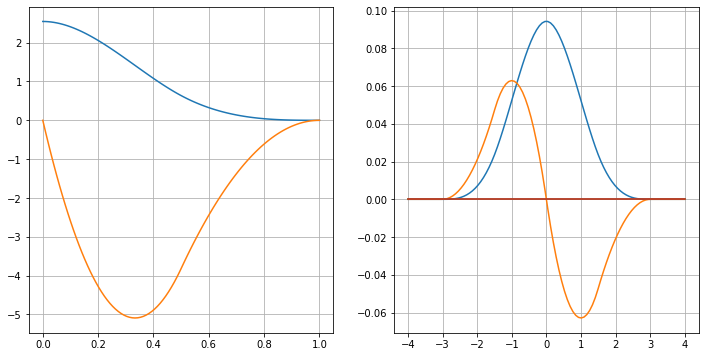

In [32]:
def W_q(q):
  
  f0 = lambda q: 6.0*(q**3 - q**2) + 1
  f1 = lambda q: 2.0*(1-q)**3
  f2 = lambda q: 0.0
  res = lax.switch(lax.mul(q, 2.0).astype(int), [f0, f1, f2], q)
  return res*8/np.pi

def W(x, h):
  return W_q(jnp.linalg.norm(x, ord=2, axis=-1)/h)/h**3
def test_W_plot():
  
  def testplot(w, rs, lsp):
 
    ws = vmap(w, 0)(rs)
    dws = vmap(grad(w), 0)(rs)
  
    plt.plot(lsp, ws)
    plt.plot(lsp, dws)
    plt.grid()
  plt.figure(figsize=(12, 6))

  plt.subplot(121)
  lsp = np.linspace(0, 1, 100)
  testplot(W_q, lsp, lsp)

  plt.subplot(122)
  w3 = partial(W, h=3.0)
  lsp = np.linspace(-4, 4, 100)
  rs = np.zeros((100, 3))
  rs[:,0] = lsp
  testplot(w3, rs, lsp)
test_W_plot()

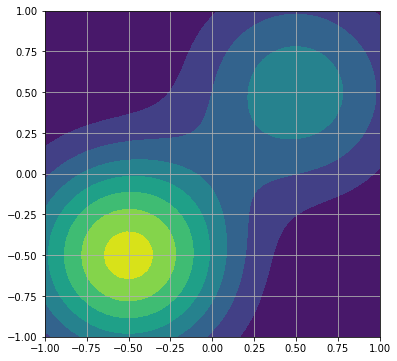

In [68]:
from jax.experimental.maps import xmap

def eval_field(x_evals, x_parts, field, w):
  
  dx = x_evals[np.newaxis, :, :] - x_parts[:, np.newaxis, :]
  w_ij = vmap(vmap(w, 0), 0)(dx)
  return (field[:, np.newaxis, :]*w_ij[:,:,np.newaxis]).sum(0)

def test_eval_field_plot():
  N = 50
  lsp = np.linspace(-1, 1, N)
  rs = np.stack(np.meshgrid(lsp, lsp, np.zeros(1)), -1)
  parts = np.array([[0.5, 0.5, 0], [-0.5, -0.5, 0]])
  field = np.array([[1.0], [2.0]])
  W_ = partial(W, h=1.4)
  res = eval_field(rs.reshape(-1, 3), parts, field, W_)
  plt.figure(figsize=(6,6))
  plt.contourf(rs[:,:,:,0].squeeze(), rs[:,:,:,1].squeeze(), res.reshape(50, 50))
  plt.grid()

test_eval_field_plot()